# Introduction to automatic differentiation

## Setup

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

%config InlineBackend.figure_format = "retina"

## Gradient tapes

Tensorflow uses a concept of a *gradient tape* which is an object that records operations during *forward pass* and then can be used to do differentiation using *backward pass*.

In [2]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2
    
dy_dx = tape.gradient(y, x)

print(dy_dx.numpy())

6.0


2021-09-09 12:19:37.795415: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now let's try it on vectors and matrices:

In [3]:
w = tf.Variable(tf.random.normal((3, 2)), name="w")
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name="b")

x = [[1.0, 2.0, 3.0]]

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)
    
dloss_dw, dloss_db = tape.gradient(loss, [w, b])

In [4]:
dloss_dw.shape

TensorShape([3, 2])

In [5]:
dloss_db.shape

TensorShape([2])

In [6]:
dloss_db

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.5676599, -4.197275 ], dtype=float32)>

In [7]:
dloss_dw.numpy()

array([[ -2.5676599,  -4.197275 ],
       [ -5.1353197,  -8.39455  ],
       [ -7.7029796, -12.5918255]], dtype=float32)

In [8]:
y.shape

TensorShape([1, 2])

In [9]:
y

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-2.5676599, -4.197275 ]], dtype=float32)>

It is possible to compute the gradients and put them in a dictionary this way:

In [10]:
grad_dict = tape.gradient(loss, {"w": w, "b": b})

In [11]:
grad_dict

{'w': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ -2.5676599,  -4.197275 ],
        [ -5.1353197,  -8.39455  ],
        [ -7.7029796, -12.5918255]], dtype=float32)>,
 'b': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.5676599, -4.197275 ], dtype=float32)>}

## Gradients with respect to model

Layers and models in Keras are subclasses of `Module` class. The instances of this class collect all their `tf.Variable`s into a special property `trainable_variables`. You can use this property to take the gradient wrt to all of these variables:

In [14]:
layer = tf.keras.layers.Dense(2, activation="relu", name="my-dense-layer")
x = tf.constant([[1.0, 2.0, 3.0]])

with tf.GradientTape() as tape:
    y = layer(x)
    loss = tf.reduce_mean(y**2)
    
grad = tape.gradient(loss, layer.trainable_variables)

for var, g in zip(layer.trainable_variables, grad):
    print(f"{var.name}, shape: {g.shape}")

my-dense-layer/kernel:0, shape: (3, 2)
my-dense-layer/bias:0, shape: (2,)


## Control of what tape watches

Gradient tape records operations with trainable `tf.Variable`s. If an operation is computed using non-trainable variables, then the computation of the gradient will fail:

In [16]:
# A trainable variable.
x0 = tf.Variable(3.0, name="x0")
# Not trainable.
x1 = tf.Variable(3.0, name="x1", trainable=False)
# Not a variable: a variable plus a tensor returns a tensor.
x2 = tf.Variable(2.0, name="x2") + 1.0
# Not a variable.
x3 = tf.constant(3.0, name="x3")

with tf.GradientTape() as tape:
    y = (x0**2) + (x1**2) + (x2**2)
    
grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
    print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


In [18]:
[var.name for var in tape.watched_variables()]

['x0:0']

In [19]:
tape.persistent

AttributeError: 'GradientTape' object has no attribute 'persistent'

To record gradients with respect to non-trainable variables, for example, `tf.Tensor`s, you can use `watch` method to explicitly enable recording:

In [21]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**4
    
dy_dx = tape.gradient(y, x)
print(f"dy_dx: {dy_dx.numpy()}")

dy_dx: 108.0


You can explicitly disable watching all trainable variables with parameter `watch_accessed_variables=False`. Then only explicitly watched variables will have gradient:

In [25]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)  # Explicitly set it to being recorded.
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)
    
grad = tape.gradient(ys, {"x0": x0, "x1": x1})
print("dy_dx0: ", grad["x0"])
print("dy_dx1: ", grad["x1"].numpy())

dy_dx0:  None
dy_dx1:  0.9999546


## Intermediate results

It is possible to compute gradients with respect to intermediate variables:

In [26]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
    z = y * y
    
# compute the gradient dz_dy = 2*y=2*x**2 = 2 * 3**2 = 18.
print(tape.gradient(z, y).numpy())

18.0


To be able to compute multiple gradients from the same tape, use `persistent=True`:

In [29]:
x = tf.constant([1.0, 3.0])

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x**2
    z = y**2
    
print(tape.gradient(z, y).numpy())  # 2*y = 2 * x**2 = [2, 18]
print(tape.gradient(z, x).numpy())  # [4, 108] (4 * x**3 at x = [1, 3])
print(tape.gradient(y, x).numpy())  # [2, 6] (2 * x at x = [1, 3])

[ 2. 18.]
[  4. 108.]
[2. 6.]


You need to explicitly delete tape now as it is persistent:

In [30]:
del tape

## Gradients of non-scalar targets

If targets are not scalars, then the sum of the gradients is calculated, as the main use case for the gradient computation is to compute the gradient with respect to loss:

In [31]:
x = tf.Variable(2.0)

with tf.GradientTape() as tape:
    y = [3.0, 4.0] * x

In [32]:
y

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([6., 8.], dtype=float32)>

In [33]:
tape.gradient(y, x).numpy()

7.0

When computing the gradients for independent non-scalar targets, that is, when each target depends only on a corresponding input variable, then the gradient is computed correctly, as gradient components of all terms vaanish except only one:

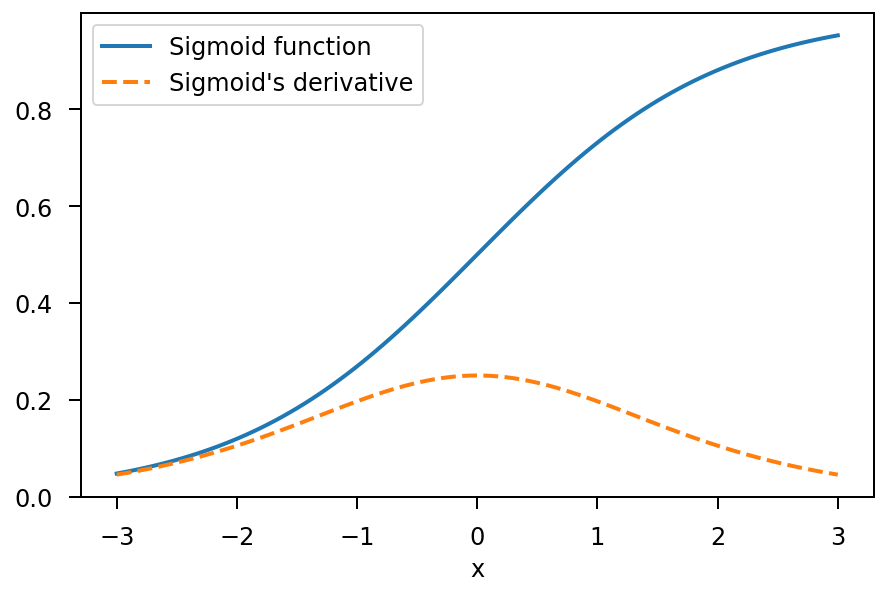

In [55]:
x = tf.linspace(-3, 3, num=101)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)
    
dy_dx = tape.gradient(y, x)

plt.figure()
plt.plot(x, y, "-", label="Sigmoid function")
plt.plot(x, dy_dx, "--", label="Sigmoid's derivative")
plt.xlabel("x")
plt.legend(loc="best")
plt.tight_layout(pad=0.1)

## Control flow

Gradient tape can handle control flow operations, like `if` or `while`.

In [56]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    
    if x > 0:
        result = v0
    else:
        result = v1**2
        
dv0, dv1 = tape.gradient(result, [v0, v1])
print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


## Dealing with `None` gradients

When the target variable does not depend on the source variable, the resulting gradient is `None`.

In [57]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as tape:
    z = y * y

print(tape.gradient(z, x))

None


There are other situations, when gradient is `None`, due to bugs.

### Using `Tensor` instead of `Variable`

If a `Variable` is replaced by `Tensor` through arithmetic operations, it will affect the gradient tape, if `watch` is not used. For example, `x` is incremented below and it changes its type to `Tensor`:

In [76]:
x = tf.Variable(3.0)

for step in range(2):
    with tf.GradientTape() as tape:
        y = x**2 + 1
        
    print(f"{type(x).__name__}:", tape.gradient(y, x))
    x = x + 1    

ResourceVariable: tf.Tensor(6.0, shape=(), dtype=float32)
EagerTensor: None


As you can see above, the type of `x` changes from `ResourceVariable` to `EagerTensor`.

To fix this behaviour, use method `assign_add`:

In [67]:
x = tf.Variable(3.0)

for step in range(2):
    with tf.GradientTape() as tape:
        y = x**2 + 1
        
    print(f"{type(x).__name__}:", tape.gradient(y, x))
    x.assign_add(1.0)

ResourceVariable tf.Tensor(6.0, shape=(), dtype=float32)
ResourceVariable tf.Tensor(8.0, shape=(), dtype=float32)


Another solution is to use `watch`:

In [77]:
x = tf.Variable(3.0)

for step in range(2):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = x**2 + 1
        
    print(f"{type(x).__name__}:", tape.gradient(y, x))
    x = x + 1    

ResourceVariable: tf.Tensor(6.0, shape=(), dtype=float32)
EagerTensor: tf.Tensor(8.0, shape=(), dtype=float32)


But, as you can see, now the type of `x` still changes. However, the gradient is computed correctly.

### 2. Did calculations outside of TensorFlow

Arithmetic operations should be done by TensorFlow to be properly recorded. If you switch to, say, `numpy` during computations, the gradients will be `None`.

In [78]:
x = tf.Variable(
    [[1.0, 2.0],
     [3.0, 4.0]],
    dtype=tf.float32
)

with tf.GradientTape() as tape:
    x2 = x**2
    
    y = np.mean(x2, axis=0)
    
    y = tf.reduce_mean(y, axis=0)
    
print(tape.gradient(y, x))

None


### 3. Using integer types accidentally

In [79]:
x = tf.constant(3)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2
    
print(tape.gradient(y, x))

None


### 4. Take gradients of stateful objects

Gradient tape does not record changes of stateful objects, that is, operations like `assign_add` of `Variable`s. Consider an example:

In [83]:
x1 = tf.Variable(3.0)
x2 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    x2.assign_add(x1)
    y = x2**2
    
print(tape.gradient(y, [x1, x2]))

[None, <tf.Tensor: shape=(), dtype=float32, numpy=6.0>]


Note that, although, on paper, y = x1^2, in practice, `y` and `x1` are disconnected as the operation `x2.assign_add(x1)` is not recorde on the gradient tape.

## No gradient registered

Some operations in Tensorflow do not implement gradients. For example, `tf.image.adjust_constrast` does not implement a gradient operation. Moreover, in such cases an exception is raised:

In [84]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
    new_image = tf.image.adjust_contrast(image, delta)
    
try:
    print(tape.gradient(new_image, [image, delta]))
    assert False  # Should not get here
except LookupError as e:
    print(f"{type(e).__name__}: {e}")

LookupError: gradient registry has no entry for: AdjustContrastv2


## Returning zero instead of `None` for unconnected gradients

Sometimes it is useful to get zero instead of `None` for unconnected gradients.
In such cases you can use `unconnected_gradients` argument:

In [86]:
x = tf.Variable([2.0, 2.0])
y = tf.Variable(3.0)

with tf.GradientTape() as tape:
    z = y**2
    
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
